## Dataset 2: Steam Games (Implicit Feedback)

### 🔹 Setup Summary
- **Data type:** Implicit feedback (playtime or ownership)
- **Filtering:** Users with ≥10 games played, games played by ≥50 users
- **Data Splitting:** Randomly hide 5 played items per user into the test set
- **Model:** Matrix Factorization (MF) for Collaborative Filtering
- **Optimization Method:** Alternating Least Squares (ALS) for implicit MF
- **Parameters Tested:** 
  - Latent factors: 32, 64, 128  
  - Regularization (λ): 0.01, 0.05, 0.1  
  - Confidence scaling (α): 10, 20, 40  
  - Iterations: 10, 20, 50
- **Evaluation Metrics:** Precision@5, Recall@5, Precision@10, Recall@10, NDCG@10

In [1]:
# import library and read dataset
import numpy as np
import pandas as pd


# --- Load dataset and drop last column ---
df = pd.read_csv('data/steam-200k.csv', header=None, names=['user_id','game','behavior','value','unused'])
df = df.drop(columns=['unused'])

In [2]:
# Remove duplicates for clarity (optional)
df = df.drop_duplicates(['user_id','game','behavior'])

In [3]:
# --- Create mappings for users and games ---
user_id_to_idx = {uid: idx for idx, uid in enumerate(df['user_id'].unique())}
game_id_to_idx = {gid: idx for idx, gid in enumerate(df['game'].unique())}

# --- Apply mappings ---
df['user_idx'] = df['user_id'].map(user_id_to_idx)
df['game_idx'] = df['game'].map(game_id_to_idx)

# Ensure integer type
df['user_idx'] = df['user_idx'].astype(int)
df['game_idx'] = df['game_idx'].astype(int)

In [5]:
# --- Build implicit feedback matrix ---
# Convert 'purchase' -> 1, 'play' -> 1 + log1p(hours)
df['feedback'] = df.apply(lambda row: 1 if row['behavior']=='purchase' else 1 + np.log1p(row['value']), axis=1)

In [6]:
# --- Filtering: users with >=10 games, games played by >=50 users ---
user_counts = df['user_idx'].value_counts()
game_counts = df['game_idx'].value_counts()
df = df[df['user_idx'].isin(user_counts[user_counts >= 10].index)]
df = df[df['game_idx'].isin(game_counts[game_counts >= 50].index)]

In [7]:
# --- Split 5 items per user for test set ---
test_list = []
train_list = []

for u, group in df.groupby('user_idx'):
    if len(group) > 5:
        test_items = group.sample(5, random_state=42)
        train_items = group.drop(test_items.index)
    else:
        test_items = pd.DataFrame(columns=df.columns)
        train_items = group
    test_list.append(test_items)
    train_list.append(train_items)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

# --- Drop any test items with unknown games (shouldn't happen after mapping, but safe) ---
test_df = test_df.dropna(subset=['game_idx'])
test_df['game_idx'] = test_df['game_idx'].astype(int)
train_df['game_idx'] = train_df['game_idx'].astype(int)

C:\Users\Jacky\AppData\Local\Temp\ipykernel_11772\466348706.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_df = pd.concat(test_list)


In [8]:
# Print dataset shapes
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}\n")

# Preview first few rows
print("Train set preview:")
display(train_df.head())

print("\nTest set preview:")
display(test_df.head())

Train set shape: (114078, 7)
Test set shape: (14745, 7)

Train set preview:


,user_id,game,behavior,value,user_idx,game_idx,feedback
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0,0,1.000000
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0,0,6.613128
2,151603712,Fallout 4,purchase,1.0,0,1,1.000000
3,151603712,Fallout 4,play,87.0,0,1,5.477337
4,151603712,Spore,purchase,1.0,0,2,1.000000



Test set preview:


,user_id,game,behavior,value,user_idx,game_idx,feedback
35,151603712,Grand Theft Auto IV,play,0.6,0,17,1.470004
5,151603712,Spore,play,14.9,0,2,3.766319
36,151603712,Realm of the Mad God,purchase,1.0,0,18,1.000000
17,151603712,Left 4 Dead,play,3.3,0,8,2.458615
23,151603712,The Banner Saga,play,2.0,0,11,2.098612


Sparse matrix shape: (2983, 767)
Number of non-zero entries: 75819
Density: 0.0331


,user_idx,game_id,feedback
0,0,0,7.613128
1,0,1,6.477337
2,0,2,1.000000
3,0,3,4.572612
4,0,4,4.292535
5,0,5,4.208274
6,0,6,1.000000
7,0,7,3.335001
8,0,8,3.252763
9,0,9,1.000000


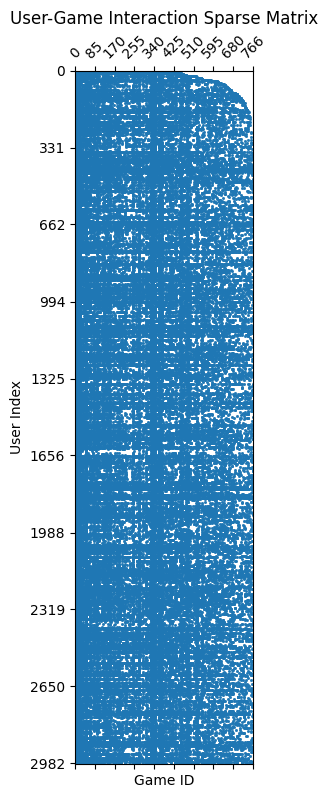

In [9]:
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt

# --- Create sparse matrix for ALS ---
train_user_map = {old: new for new, old in enumerate(train_df['user_idx'].unique())}
train_game_map = {old: new for new, old in enumerate(train_df['game_idx'].unique())}

train_df['user_sparse_idx'] = train_df['user_idx'].map(train_user_map)
train_df['game_sparse_idx'] = train_df['game_idx'].map(train_game_map)

n_train_users = len(train_user_map)
n_train_games = len(train_game_map)

train_sparse = coo_matrix(
    (train_df['feedback'], (train_df['user_sparse_idx'], train_df['game_sparse_idx'])),
    shape=(n_train_users, n_train_games)
).tocsr()

# --- Map test set to same training indices, drop unknowns ---
test_df['user_sparse_idx'] = test_df['user_idx'].map(train_user_map)
test_df['game_sparse_idx'] = test_df['game_idx'].map(train_game_map)
test_df = test_df.dropna(subset=['user_sparse_idx', 'game_sparse_idx'])
test_df['user_sparse_idx'] = test_df['user_sparse_idx'].astype(int)
test_df['game_sparse_idx'] = test_df['game_sparse_idx'].astype(int)

# --- Display summary ---
print(f"Sparse matrix shape: {train_sparse.shape}")
print(f"Number of non-zero entries: {train_sparse.nnz}")
print(f"Density: {train_sparse.nnz / (n_train_users * n_train_games):.4f}")

# --- Show first 10 non-zero entries ---
rows, cols = train_sparse.nonzero()
sample_df = pd.DataFrame({
    'user_idx': rows[:10],
    'game_id': cols[:10],
    'feedback': train_sparse[rows[:10], cols[:10]].A1
})
display(sample_df)

# --- Visualize sparse matrix ---
plt.figure(figsize=(12,9))
plt.spy(train_sparse, markersize=1)
plt.title("User-Game Interaction Sparse Matrix")
plt.xlabel("Game ID")
plt.ylabel("User Index")

# Set ticks with at most 10 labels for readability
x_max, y_max = train_sparse.shape[1], train_sparse.shape[0]
x_ticks = np.linspace(0, x_max-1, min(10, x_max), dtype=int)
y_ticks = np.linspace(0, y_max-1, min(10, y_max), dtype=int)
plt.xticks(x_ticks, x_ticks, rotation=45)
plt.yticks(y_ticks, y_ticks)
plt.show()


In [10]:
# Evaluation Metrics for Recommendation
import numpy as np

def precision_at_k(recommended, relevant, k):
    """
    Compute Precision@K.
    
    Parameters:
        recommended (list): List of recommended item IDs
        relevant (list or set): List or set of relevant item IDs
        k (int): Number of top recommendations to consider
        
    Returns:
        float: Precision@K
    """
    recommended_k = recommended[:k]
    return len(set(recommended_k) & set(relevant)) / k

def recall_at_k(recommended, relevant, k):
    """
    Compute Recall@K.
    
    Parameters:
        recommended (list): List of recommended item IDs
        relevant (list or set): List or set of relevant item IDs
        k (int): Number of top recommendations to consider
        
    Returns:
        float: Recall@K
    """
    if not relevant:
        return 0.0
    recommended_k = recommended[:k]
    return len(set(recommended_k) & set(relevant)) / len(relevant)

def ndcg_at_k(recommended, relevant, k):
    """
    Compute Normalized Discounted Cumulative Gain (NDCG)@K.
    
    Parameters:
        recommended (list): List of recommended item IDs
        relevant (list or set): List or set of relevant item IDs
        k (int): Number of top recommendations to consider
        
    Returns:
        float: NDCG@K
    """
    recommended_k = recommended[:k]
    dcg = sum(1 / np.log2(i + 2) for i, item in enumerate(recommended_k) if item in relevant)
    # Ideal DCG (best possible ranking)
    idcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant), k)))
    return dcg / idcg if idcg > 0 else 0

In [11]:
import numpy as np
import pandas as pd
from implicit.als import AlternatingLeastSquares
from tqdm.notebook import tqdm

factors_list = [32, 64, 128]
reg_list = [0.01, 0.05, 0.1]
alpha_list = [10, 20, 40]
iterations_list = [10, 20, 50]

results = []

hyperparams = [
    (factors, reg, alpha, iterations)
    for factors in factors_list
    for reg in reg_list
    for alpha in alpha_list
    for iterations in iterations_list
]

for factors, reg, alpha, iterations in tqdm(hyperparams, desc="Hyperparameter Search", ncols=120):
    # --- Train ALS Model ---
    model = AlternatingLeastSquares(
        factors=factors,
        regularization=reg,
        iterations=iterations,
        calculate_training_loss=False
    )
    confidence = (train_sparse * alpha).astype('double')
    model.fit(confidence.T)  # ALS expects items x users

    # --- Evaluate on Test Set ---
    metrics = {5: {'prec': [], 'rec': [], 'ndcg': []},
               10: {'prec': [], 'rec': [], 'ndcg': []}}
    
    # --- Only use users that exist in train_sparse ---
    valid_test_df = test_df[test_df['user_sparse_idx'].isin(range(train_sparse.shape[0]))]

    for u in tqdm(range(train_sparse.shape[0]), desc="Evaluating Users", leave=False):
        train_items = set(train_df[train_df['user_sparse_idx'] == u]['game_sparse_idx'])
        test_items = set(valid_test_df[valid_test_df['user_sparse_idx'] == u]['game_sparse_idx'])
        
        if not train_items or not test_items:
            continue

        user_row = train_sparse[u, :]
        recommended_scores = model.recommend(
            userid=u,
            user_items=user_row,
            N=train_sparse.shape[1],
            filter_already_liked_items=True
        )

        recommended = recommended_scores[0] if isinstance(recommended_scores, tuple) else [i for i, _ in recommended_scores]

        for k in [5, 10]:
            metrics[k]['prec'].append(precision_at_k(recommended, test_items, k))
            metrics[k]['rec'].append(recall_at_k(recommended, test_items, k))
            metrics[k]['ndcg'].append(ndcg_at_k(recommended, test_items, k))

    # --- Save Results ---
    results.append({
        'factors': factors,
        'reg': reg,
        'alpha': alpha,
        'iterations': iterations,
        'precision@5': np.mean(metrics[5]['prec']),
        'recall@5': np.mean(metrics[5]['rec']),
        'ndcg@5': np.mean(metrics[5]['ndcg']),
        'precision@10': np.mean(metrics[10]['prec']),
        'recall@10': np.mean(metrics[10]['rec']),
        'ndcg@10': np.mean(metrics[10]['ndcg']),
    })

# --- Display Top Results ---
results_df = pd.DataFrame(results).sort_values('ndcg@10', ascending=False)
display(results_df.head(10))

Hyperparameter Search:   0%|                                                                     | 0/81 [00:00…

C:\Users\Jacky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 20 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
C:\Users\Jacky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0 seconds
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating Users:   0%|          | 0/2983 [00:00<?, ?it/s]

IndexError: index 767 is out of bounds for axis 0 with size 767